# Calib CC Counts Corr

    This notebook holds a regression for the cell-count measurements done with CoulterCC on individual wells
    
    
    However, these linear models are not used to go from A560. Instead, we used used the theoretical cell-counts stemming from the A1 well cell-counts and dilution factors used in the col-12 and row-H

In [2]:
import numpy as np
import pandas as pd
import os
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

from os.path import join as pjoin
import itertools as it

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Data

In [3]:
pd.options.display.max_rows = 99


In [4]:
path = '../data_o/calibration/community_calibration/parsed_data/'
fname = 'calib_exp2-cell_counter_results.tsv'

In [5]:
df = pd.read_csv(pjoin(path,fname), sep='\t', date_parser=['cc_sampling_time'])

# Process

In [6]:
df.head(2)
dft = df.copy()
dft = dft.rename({'cc_sampling_time':'date_time',
                  'type_of_cell':'cell_type',
                  'Sample_concentration':'concentration',
                  'Filename':'well'}, axis=1).drop('Filename_full', axis=1)

# add well and rep columns from the filename
# rep is used to calculate stdev
dft['well'] = dft['well'].str[20:25]
dft['rep'] = dft['well'].str[3:]
dft['well'] = dft['well'].str[0:2]

# datetime isn't needed, drop it
dft = dft[['well', 'rep', 'concentration', 'cell_type']]

# segreate the groups
x2gb = dft.groupby(by='cell_type')

# clean up the misnamings that occur before
syncom_cal_cc = []
for name, group in x2gb:
    group = group.copy()
    group.loc[group['well']=='F1', 'well'] = 'F11'
    group.loc[group['well']=='G1', 'well'] = 'G12'
    
    
    group.loc[group['well']=='F11', 'rep'] = ['01', '02', '03', '04']
    group.loc[group['well']=='G12', 'rep'] = ['01', '02', '03', '04']
    #group.head()
    syncom_cal_cc.append(group.drop(labels=['cell_type'], axis=1))

#syncom_cal_cc[0].head(2)

# Mean & Standard Deviation Calculation and DF reformatting
syncom_cal_cc_dfs = []
for df in syncom_cal_cc:
    tdf = df.groupby(['well'], as_index=False).agg({'concentration':['mean', 'std']})
    tdf.columns = ['well', 'conc_mean', 'conc_std']
    tdf = tdf.sort_values(by=['well'])
    tdf = tdf.set_index('well')
    syncom_cal_cc_dfs.append(tdf)

    tdf.head(3)

,Filename_full,Sample_concentration,cc_sampling_time,Filename,type_of_cell
0,./data/JF_chlamy_calib_exp_A1_01.#m4,7.064344e+08,2019-09-09 20:03:23,JF_chlamy_calib_exp_A1_01.#m4,b
1,./data/JF_chlamy_calib_exp_A1_01.#m4,4.325864e+06,2019-09-09 20:03:23,JF_chlamy_calib_exp_A1_01.#m4,c


,conc_mean,conc_std
well,,
A1,7.576081e+08,3.435945e+07
B3,6.913552e+08,3.590434e+07
C2,8.027593e+08,3.300604e+08


,conc_mean,conc_std
well,,
A1,4.563062e+06,2.113633e+05
B3,3.075544e+06,2.268306e+05
C2,6.221444e+06,8.091050e+06


In [7]:
B_c = syncom_cal_cc_dfs[0]
C_c = syncom_cal_cc_dfs[1]

# Load Pred Vals @ Respective Wells
    
    We can only regress to cell-counts once we have 'disambiguated' the signals into each analytes respective fraction. We first load these fractions and run a linear regression on them B_p vs. B_cc and C_p vs. C_cc using sklearn regression library... we then save these regression coefficients and apply them to older data's B_p and C_p values. We have to do it this way because we don't bacter_column nor chlamy_row only vs cell counts data

In [9]:
save_to = "../data_o/calibration/community_calibration/predicted_fractions"
fname =  'a680_a720_pred_fractions.csv'

In [10]:
pred = pd.read_csv(pjoin(save_to, fname), index_col=0)
pred.head(2)
B_c = syncom_cal_cc_dfs[0]
C_c = syncom_cal_cc_dfs[1]

idx = B_c.index.values
pred_relevant = pred.loc[idx,:]

####################################################
# HERE YOU CAN SELECT A DIFFERENT WAVELENGHT AS YOUR 
# REGRESSAND, just replace the Ns e.g. 'B_pNNN'
B_p = pred_relevant[['B_p560']]
C_p = pred_relevant[['C_p560']]
####################################################


Bs = pd.concat([B_p, B_c], axis=1)
Cs = pd.concat([C_p, C_c], axis=1)

Bs = Bs.rename({'conc_mean':'B_cc_mean', 'conc_std':'B_cc_std'},axis=1)
Cs = Cs.rename({'conc_mean':'C_cc_mean', 'conc_std':'C_cc_std'},axis=1)

Bs.sort_values(by='B_p560')
Cs.sort_values(by='C_p560')

Bs = Bs.drop(['C4'])
Cs = Cs.drop(['C2'])


,row,col,B_lbl,C_lbl,A600,A600_sdv,A680,A680_sdv,A720,A720_sdv,...,B_p710,C_p710,B_p720,C_p720,B_p730,C_p730,B_p740,C_p740,B_p750,C_p750
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.4,0.50,1.0938,0.0618,1.4928,0.0686,0.8732,0.0660,...,0.255450,0.656874,0.251179,0.619558,0.246193,0.596086,0.242318,0.583480,0.237911,0.571970
A2,A,2,0.4,0.46,1.0292,0.0746,1.3929,0.0742,0.8300,0.0714,...,0.270676,0.593367,0.266130,0.559659,0.260821,0.538457,0.256701,0.527069,0.252017,0.516673


,B_p560,B_cc_mean,B_cc_std
well,,,
H2,0.043251,1.765423e+07,6.993885e+06
G12,0.151826,4.460765e+08,1.089202e+07
G6,0.175830,2.383185e+08,1.438233e+07
F11,0.233966,6.546206e+08,2.333176e+07
E4,0.252080,7.872921e+08,2.689878e+07
C2,0.291018,8.027593e+08,3.300604e+08
E9,0.300049,7.627460e+08,3.579532e+07
B3,0.337626,6.913552e+08,3.590434e+07
A1,0.341187,7.576081e+08,3.435945e+07


,C_p560,C_cc_mean,C_cc_std
well,,,
G12,-0.004968,2.542852e+05,2.979289e+04
F11,0.124687,1.217152e+06,4.208553e+04
E9,0.236826,1.673458e+06,1.040310e+05
D7,0.365791,3.046397e+06,3.680935e+05
G6,0.417083,1.008095e+06,1.339587e+05
C5,0.490983,2.190069e+06,1.010359e+05
E4,0.532407,4.402250e+06,2.203976e+05
C4,0.552461,5.141988e+06,2.828260e+05
B3,0.593879,3.075544e+06,2.268306e+05


<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

(-1000000.0, 10000000.0)

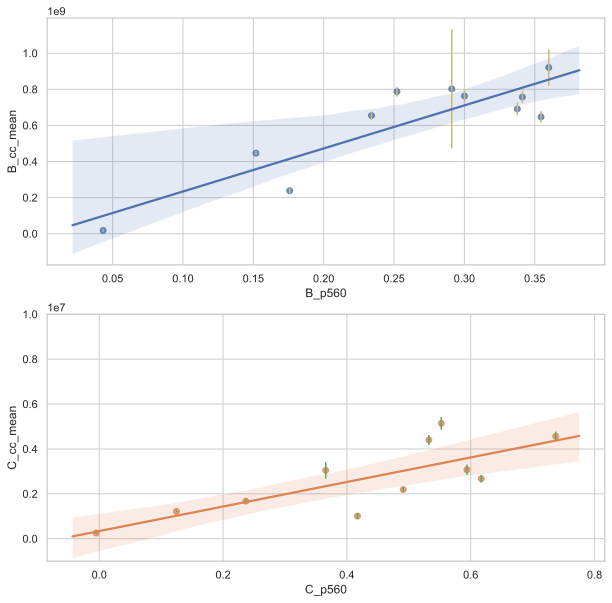

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
sns.regplot(data=Bs, x='B_p560', y='B_cc_mean', ax=ax[0])
ax[0].errorbar(x=Bs['B_p560'], y=Bs['B_cc_mean'], yerr=Bs['B_cc_std'], fmt='none', color='y')


sns.regplot(data=Cs, x='C_p560', y='C_cc_mean', ax=ax[1])
ax[1].errorbar(x=Cs['C_p560'], y=Cs['C_cc_mean'], yerr=Cs['C_cc_std'], fmt='none')
ax[1].set_ylim(-1e6, 1e7)


In [12]:
reg_df = pd.concat([Bs, Cs], axis=1, sort=False)

In [13]:
reg_df

,B_p560,B_cc_mean,B_cc_std,C_p560,C_cc_mean,C_cc_std
A1,0.341187,7.576081e+08,3.435945e+07,0.737230,4.563062e+06,211363.293015
B3,0.337626,6.913552e+08,3.590434e+07,0.593879,3.075544e+06,226830.581252
C2,0.291018,8.027593e+08,3.300604e+08,NaN,NaN,NaN
C5,0.354447,6.472141e+08,3.075924e+07,0.490983,2.190069e+06,101035.938001
D7,0.359926,9.209818e+08,1.008105e+08,0.365791,3.046397e+06,368093.477276
E4,0.252080,7.872921e+08,2.689878e+07,0.532407,4.402250e+06,220397.605274
E9,0.300049,7.627460e+08,3.579532e+07,0.236826,1.673458e+06,104031.021938
F11,0.233966,6.546206e+08,2.333176e+07,0.124687,1.217152e+06,42085.529983
G12,0.151826,4.460765e+08,1.089202e+07,-0.004968,2.542852e+05,29792.889888
G6,0.175830,2.383185e+08,1.438233e+07,0.417083,1.008095e+06,133958.704277


# Regression
    
    Regressands B_p and C_p @ 560
    Regressors B_cc and C_cc 

In [14]:
def get_pred_to_cc_regr_coefs(df, regressor, regressand):
    """
    The following function returns the coefficients of a regression involving
    predicted singal to cell counts.
    """
    from sklearn.linear_model import LinearRegression
    # use respective signals
    y = df[regressor].dropna()
    x = df[regressand].dropna().values
    
    # regress to obtain coefficient
    lin_regr= LinearRegression()
    kZ = lin_regr.fit(X=x.reshape(-1,1), y=y)
    
    
    return kZ

In [15]:
kZ_B = get_pred_to_cc_regr_coefs(reg_df, regressand='B_p560', regressor='B_cc_mean')
kZ_C = get_pred_to_cc_regr_coefs(reg_df, regressand='C_p560', regressor='C_cc_mean')

# sa

In [16]:
def apply_pred_to_cc(df, kZ_B, kZ_C):
    pass
    ### how does this function handle 
